In [1]:
# Python SQL toolkit and Object Relational Mapper
import pandas as pd
import numpy as np
import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from datetime import date
from dateutil.relativedelta import relativedelta
from sqlalchemy import create_engine, inspect, func, desc
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.db")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measures = Base.classes.measures
Stations = Base.classes.stations
session = Session(engine)

In [3]:
def get_prior_years_date (string_date, yrs, format_date='%Y-%m-%d'):
    '''
    From string date return last year's same date in string format. 
    '''
    try:
        months_back = yrs * -12
        converted_date = datetime.datetime.strptime(string_date, format_date) # to datetime for math
        temp_date = converted_date + relativedelta(months = months_back) # do math
        prior_date = (temp_date.strftime('%Y-%m-%d')) # back to string
        return(prior_date)
    except exception as e:
        print(e)    

In [4]:
# Query for most recent date in Measures
recent_date = session.query(Measures.date).order_by('Measures.date desc').first()
# Get string value of recent date from tuple return by query
recent_date = recent_date[0]
# Get string value of 1 year prior to recent date
prior_date = get_prior_years_date(recent_date,1)

C:\Users\billw\Anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'Measures.date desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [5]:
# Select date and precipitation from Measures for 12 months prior to most recent measurement  
sel = [Measures.date, Measures.prcp]
last_twelve_mths_measures = session.query(*sel).\
    filter(Measures.date >= prior_date[1]).\
    filter(Measures.date <= recent_date).\
    order_by(Measures.date).all()

<IPython.core.display.Javascript object>


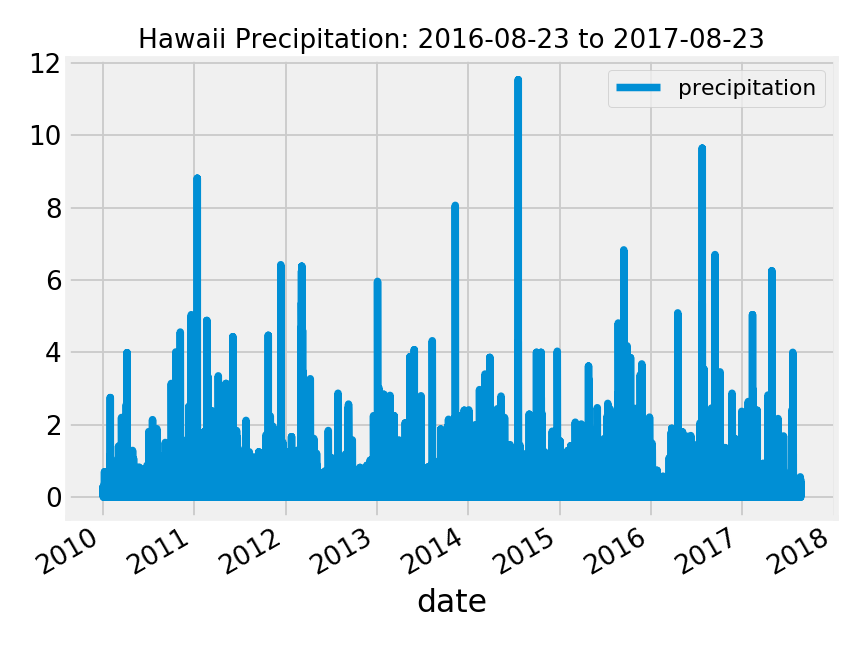

In [6]:
# Use Pandas plot to create chart for precipitation
df = pd.DataFrame(last_twelve_mths_measures, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date',inplace=True)
df.plot(x_compat=True).legend(loc='best',fontsize='small')
plt.title('Hawaii Precipitation: %s to %s' % (prior_date, recent_date),fontsize='medium')
plt.tight_layout()
plt.show()

In [7]:
print('precipitation statistic:')
df.describe(include='all')

precipitation statistic:


,precipitation
count,19550.000000
mean,0.160644
std,0.451064
min,0.000000
25%,0.000000
50%,0.020000
75%,0.160644
max,11.530000


In [8]:
sel = [func.count(Stations.station)]
count_of_stations_query = session.query(*sel).all()
station_count, = count_of_stations_query
print('Total number of stations: %s' % (station_count))

Total number of stations: 9


In [9]:
sel = [Measures.station, func.count(Measures.station)]
station_activity_query = session.query(*sel).group_by(Measures.station).\
order_by(desc(func.count(Measures.station))).all()
print('List of stations in descending activity order:')
station_activity_query

List of stations in descending activity order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [10]:
# set up list of selected values from Stations and Measures
sel = [Stations.station, Stations.name, func.count(Measures.station)]
# Join Station with Measures on station and return the station_no and name having
# the highest count of associated Measures records.
station_activity_query = session.query(*sel).\
    filter(Stations.station == Measures.station).\
group_by(Stations.station).\
order_by(desc(func.count(Measures.station))).first()

ma_station_no = station_activity_query[0]
ma_station_name = station_activity_query[1]

print('Station with most activity: %s (%s)' % (ma_station_name, ma_station_no))

Station with most activity: WAIHEE 837.5, HI US (USC00519281)


In [11]:
# Select date and tobs from Measures for 12 months prior to most recent measurement  
sel = [Measures.date, Measures.tobs]
last_twelve_mths_tobs = session.query(*sel).\
    filter(Measures.date >= prior_date).\
    filter(Measures.date <= recent_date).\
    filter(Measures.station == ma_station_no).\
    order_by(Measures.tobs).all()
# Convert from tuple temp list to list of temps
last_twelve_mths_tobs
tobs = last_twelve_mths_tobs
tobs_list = [i[1] for i in tobs]

<IPython.core.display.Javascript object>


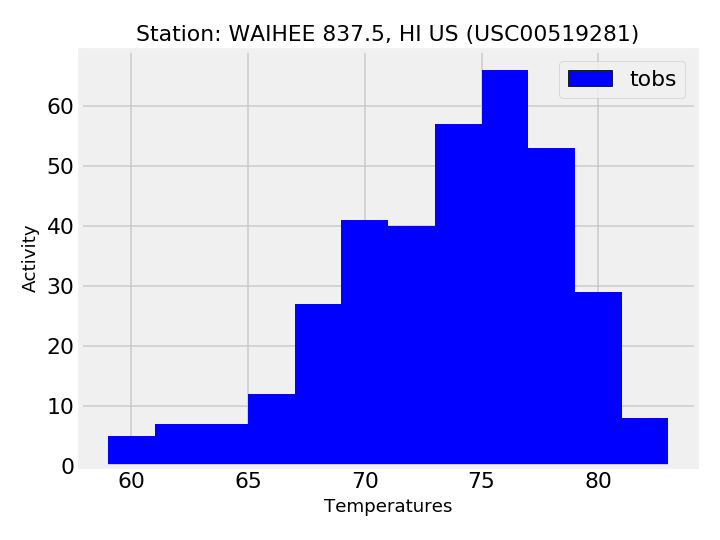

In [12]:
# Plot histogram of temp observations for most active station
#create legend
handles = [Rectangle((0,0),1,1,color="blue",ec="k")]
labels= ["tobs"]
plt.legend(handles, labels)
plt.hist(tobs_list, bins=12, color="blue")
plt.xlabel('Temperatures', fontsize='small')
plt.ylabel('Activity', fontsize='small')
plt.title('Station: %s (%s)' % (ma_station_name, ma_station_no),fontsize='medium')
plt.tight_layout()
plt.show()

In [13]:
# USC00511918 Honolulu from 7-2-2018 to 7-16-2018()
def calc_temps (start_date, end_date, yrs, station='USC00511918'):
    """ 
        From  station (default UC00511918), start_date, and end_date
        Return avg, max and min tobs from same date range for the previous year
        If data not found then select again for the next previous year range... repeat until
        data is found or user specified years have been searched.
        *** Note USC00511918 didn't have data until 7-2-2015 t0 7-16-2015
    """ 
    # prior_start = datetime.datetime.strptime(start_date,'%Y-%m-%d')
    # Get string value of 1 year prior to start date
    prior_start_date = get_prior_years_date(start_date,1) 
    prior_end_date = get_prior_years_date(end_date,1)
    counter = 0
    while (counter < yrs):
        try:
            sel = [ 
               func.avg(Measures.tobs), 
               func.max(Measures.tobs), 
               func.min(Measures.tobs)
                   ]
            prior_year_calcs = session.query(*sel).\
                filter(Stations.station == station).\
                filter(Stations.station == Measures.station).\
                filter(Measures.date >= prior_start_date).\
                filter(Measures.date <= prior_end_date).\
            group_by(Stations.station).all()
            if len(prior_year_calcs) == 0:
                prior_start_date = get_prior_years_date(prior_start_date,1)
                prior_end_date = get_prior_years_date(prior_end_date,1)
            else:
                return prior_year_calcs
                break
            counter +=1
        except exception as e:
            print(e)

In [14]:
years = input('Number of years to search back for data --> ')
print('Analyze dates (from future Honolulu Vacation dates) for %s years back' % (years)) 
results = calc_temps('2018-07-02','2018-07-16',int(years))
results = list(np.ravel(results))
results

Number of years to search back for data --> 3
Analyze dates (from future Honolulu Vacation dates) for 3 years back


[74.375, 77.0, 71.0]

<IPython.core.display.Javascript object>


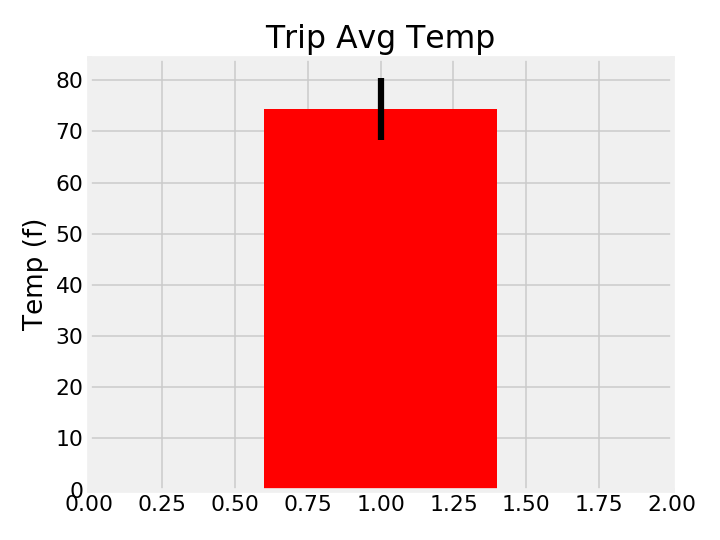

In [15]:
# Plot single bar for trip avg temp and include terr of tmax-tmin
average = results[0]
tmax = results[1]
tmin = results[2]
terr = tmax - tmin
plt.bar(1, average, color='r', yerr=terr)
# add some text for labels, title and axes ticks
plt.ylabel('Temp (f)')
plt.title('Trip Avg Temp')
plt.xlim([0, 2])
#plt.axis('off')
plt.tight_layout()
plt.show()


In [16]:
def rainfall_per_weather_station (start_date, end_date):
    """ 
        From probable vacation 2018 start_date, and end_dates
        return rainfall per weatherstation from same date range for the previous year
    """ 
    # prior_start = datetime.datetime.strptime(start_date,'%Y-%m-%d')
    # Get string value of 1 year prior to start date
    prior_start_date = get_prior_years_date(start_date,1) 
    prior_end_date = get_prior_years_date(end_date,1)
    sel = [ 
       Stations.station, 
       Stations.name, 
       func.sum(Measures.tobs)
           ]
    results = session.query(*sel).\
        filter(Stations.station == Measures.station).\
        filter(Measures.date >= prior_start_date).\
        filter(Measures.date <= prior_end_date).\
    group_by(Stations.station).all()
    return results
results = rainfall_per_weather_station('2018-07-02','2018-07-16')
results

[('USC00513117', 'KANEOHE 838.1, HI US', 1157),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 964),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 1133),
 ('USC00517948', 'PEARL CITY, HI US', 645),
 ('USC00519281', 'WAIHEE 837.5, HI US', 1142),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 1195),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 1124)]